# Classification Problem -- Decision Tree -- Classification Tree
<br>
**Pros**: Computationally cheap to use, easy for humans to understand learned results, missing values OK, can deal with irrelevant features

**Cons**: Prone to overfitting

**Works with**: Numeric values, nominal values
<br><br>
<font size=3>kNN最大的缺点就是无法给出数据的内在含义，决策树的优势就在于数据形式非常容易理解。
<br>
一些决策树算法采用二分法划分数据，这里我们用<font color='red'>**ID3算法**</font>：
<br>
<br>
(1)The ID3 algorithm begins with the original set *S* as the root node. 
<br>
<br> 
(2)On each iteration of the algorithm, it iterates through every unused attribute of the set *S* and calculates the entropy *H(S)* of that attribute. 
<br>
<br>
(3)It then selects <font color='green'>the attribute which has the smallest entropy (or largest information gain) value</font>. 
<br>
<br>
(4)The set *S* is then split by the selected attribute (e.g. age is less than 50, age is between 50 and 100, age is greater than 100) to produce subsets of the data. <font color='green'>Note: each split may return two or more branches</font>.
<br>
<br>
(5)The algorithm continues to recurse on each subset, <font color='green'>considering only attributes never selected before</font>.
</font>

In [1]:
from math import log

<font size = 3.5>
<font color='green'>**补充一点知识**</font>：如何度量数据的无序程度（impurity）？
<br>
<br>
In pure node, all the responses in one node are the same. If not so, the impurity occurs.
<br>
<br>
1. Regression Tree: RSS.
<br>
<br>
2. Classification Tree
<br>
<br>
(0)$\hat{p_{km}} = \frac{1}{N_m} \sum_{x_i \in R_m}I(y_i = k)$, which is the proportion of class k observations in node m. And we classify observations in node m to class $k(m) = argmax_{k}\hat{p_{km}}$.
<br>   
(1)Misclassification Error Rate: $\frac{1}{N_m} \sum_{i \in R_m}I(y_i \ne k(m)) = 1-\hat{p_{km}}$.
<br>
<br> 
(2)Gini Index: $\sum_{k \ne k'}\hat{p_{km}}\hat{p_{k'm}} = \sum_{k \ne k'}\hat{p_{km}}(1-\hat{p_{km}})$.
<br>
<br>
(3)Cross-entropy or Deviance: $-\sum_{k \ne k'} \hat p_{mk} log \hat p_{mk}$.
<br>
<br>    
**Notes about Information and Entropy**:
<br>
<br>
If you’re classifying something that can take on multiple values, the <font color = red>**information**</font> for symbol $x_i$ is defined as
$$l(x_i) = -logP(x_i)$$
where $P(x_i)$ is the probability of choosing this class.
<br>
To calculate  <font color = red>**entropy (also as shannon entropy)**</font>, you need the expected value of all the information of all possible values of our class. This is given by
$$H = E[l(x_i)] = –\sum_{i = 1}^{n} P(x_i)logP(x_i)$$
</font>

## 1. Create the decision tree
### 1.1 Def the function

In [2]:
def cal_entropy(dataset):
    num_entries = len(dataset)
    label_counts = {}
    for feature_vec in dataset:                   
        current_label = feature_vec[-1]
        if current_label not in label_counts.keys(): 
            label_counts[current_label] = 0
        label_counts[current_label] += 1
    entropy = 0.0
    for key in label_counts:
        prob = float(label_counts[key])/num_entries
        entropy -= prob * log(prob) 
    return entropy

### 1.2 create data for test

In [3]:
def create_dataset():
    dataset = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    return dataset, labels

In [4]:
my_data, labels = create_dataset()
cal_entropy(my_data)

0.6730116670092565

**The larger the entropy, the higher the impurity.**

### 1.3 split the data set
For our classifier algorithm to work, you need to measure the entropy, split the dataset, measure the entropy on the split sets, and see if splitting it was the right thing to do.

In [5]:
def split_dataset(dataset, axis, value):
    ret_dataset = []
    for feature_vec in dataset:
        if feature_vec[axis] == value:
            reduced_feature_vec = feature_vec[:axis]      
            reduced_feature_vec.extend(feature_vec[axis+1: ])     #chop out axis used for splitting
            ret_dataset.append(reduced_feature_vec)
    return ret_dataset

*Some coding notes*:

In [6]:
for feature_vec in my_data[0:2]:
    print(feature_vec[2])
    print(feature_vec[:2])       # select the columns before axis = 2

    
# append() vs. extend()   
a = [1,2,3]
b = [4,5,6]
a.append(b)
print(a)
a = [1,2,3]
a.extend(b)
print(a)

yes
[1, 1]
yes
[1, 1]
[1, 2, 3, [4, 5, 6]]
[1, 2, 3, 4, 5, 6]


Let’s try out the split_dataset() function on our former simple example.

In [7]:
print(split_dataset(my_data, 0, 1))
print(split_dataset(my_data, 0, 0))

[[1, 'yes'], [1, 'yes'], [0, 'no']]
[[1, 'no'], [1, 'no']]


<font size = 3.5>**Combine the Shannon entropy calculation and the split_dataset() function to <font color = 'red'>cycle through</font> the dataset and decide which feature is the best to split on.**</font>

In [8]:
def choose_best_feature_tosplit(dataset):
    num_features = len(dataset[0]) - 1            #calculate the number of column and the last column is used for labels
    base_entropy = cal_entropy(dataset)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):                 #iterate over all the features
        feature_list = [example[i] for example in dataset]       #create a list of all the examples of this feature
        unique_vals = set(feature_list)           #get a set of unique values
        new_entropy = 0.0
        for value in unique_vals:
            sub_dataset = split_dataset(dataset, i, value)
            prob = len(sub_dataset)/float(len(dataset))
            new_entropy += prob * cal_entropy(sub_dataset)     
        info_gain = base_entropy - new_entropy    #calculate the info gain, i.e., reduction in entropy
        if (info_gain > best_info_gain):          #compare this to the best gain so far
            best_info_gain = info_gain            #if better than current best, set to best
            best_feature = i
    return best_feature                           #returns an integer


In [9]:
choose_best_feature_tosplit(my_data)

0

### 1.4 recursively building the tree
<br>
<font size = 3.5>Start with our dataset and split it based on the best attribute to split. (*These may not be binary trees, so you can handle more than two-way splits.*) Once split, the data will traverse down the branches of the tree to another node. This node will then split the data again. You’re going to use the principle of <font color = 'red'>**recursion**</font> to handle this.
<br>
<br>
**Stopping Rule**: Run out of attributes on which to split or all the instances in a branch are the same class.

即每个分支内的节点都属于同一类。
<br>
<br>
We could also set a bound on the maximum number of splits we can have.
<br>
<br>
If our dataset has run out of attributes but the class labels are not all the same, we must decide what to call that leaf node. In this situation, we’ll take a majority vote.
</font>

In [10]:
import operator

In [11]:
# majority vote function
def majority_count(class_list):
    class_count={}
    for vote in class_list:
        if vote not in class_count.keys(): 
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_class_count[0][0]


In [12]:
def create_tree(dataset, labels):
    class_list = [example[-1] for example in dataset]
                                             # create a list of all the class labels in our dataset
    if class_list.count(class_list[0]) == len(class_list): 
        return class_list[0]                 #stop splitting when all of the classes are equal
    if len(dataset[0]) == 1:              
        return majority_count(class_list)    #stop splitting when there are no more features in dataSet
    best_feature = choose_best_feature_tosplit(dataset)
    best_feature_label = labels[best_feature]
    my_tree = {best_feature_label:{}}
    del(labels[best_feature])                #split on one feature only once
    feature_values = [example[best_feature] for example in dataset]
    unique_vals = set(feature_values)
    for value in unique_vals:
        sub_labels = labels[:]               #copy all of labels, so trees don't mess up existing labels
        my_tree[best_feature_label][value] = create_tree(split_dataset(dataset, best_feature, value), sub_labels)
                                             #recursively use this function
    return my_tree                    

In [13]:
# Notes for coding
a = [0,0,0,1,1,1,2,2,5]
a.count(a[0])

3

In [14]:
my_tree = create_tree(my_data, labels)

my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## 2. Plot the decision tree
### 2.1 Plot the node

In [15]:
import matplotlib.pyplot as plt

decision_node = dict(boxstyle="sawtooth", fc="0.8")
leaf_node = dict(boxstyle="round4", fc="0.8")                 #定义文本框
arrow_args = dict(arrowstyle="<-")                            #定义箭头格式

def plot_node(node_txt, center_pt, parent_pt, node_type):     #绘制带箭头的注解
    create_plot.ax1.annotate(node_txt, xy=parent_pt,  xycoords='axes fraction',
             xytext=center_pt, textcoords='axes fraction',
             va="center", ha="center", bbox=node_type, arrowprops=arrow_args)

In [16]:
def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()           
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node('Decision Node', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node('Leaf Node', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()


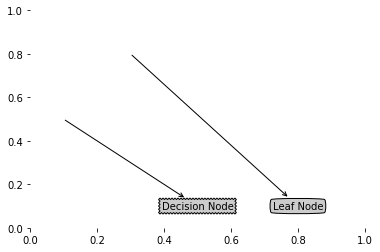

In [17]:
create_plot()

### 2.2 Identifying the number of leaves in a tree and the depth

In [18]:
# 获取叶节点的数目

def get_leaf_num(my_tree):
    leaf_num = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':
            #test to see if the nodes are dictonaires, if not they are leaf nodes
            leaf_num += get_leaf_num(second_dict[key])
        else:   
            leaf_num += 1
    return leaf_num


In [19]:
# 获取树的层数

def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':
            #test to see if the nodes are dictonaires, if not they are leaf nodes
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:   
            this_depth = 1
        if this_depth > max_depth: 
            max_depth = this_depth
    return max_depth

In [20]:
# 预先存储树信息用于检测

def retrieve_tree(i):
    list_of_trees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return list_of_trees[i]

In [21]:
# 用预存的树信息进行test

print(retrieve_tree(0))
print(retrieve_tree(1))

print(get_leaf_num(retrieve_tree(0)))
print(get_leaf_num(retrieve_tree(1)))
print(get_tree_depth(retrieve_tree(0)))
print(get_tree_depth(retrieve_tree(1)))

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
{'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
3
4
2
3


### 2.3 Plot the decision tree

In [22]:
def plot_mid_text(cntr_pt, parent_pt, txt_string):     # 计算父节点与子节点的中间位置，并添加文本信息
    x_mid = (parent_pt[0]-cntr_pt[0])/2.0 + cntr_pt[0]
    y_mid = (parent_pt[1]-cntr_pt[1])/2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string, 
                         va="center", ha="center", rotation=30)


def plot_tree(my_tree, parent_pt, node_txt):           # if the first key tells you what feat was split on
    leaf_num = get_leaf_num(my_tree)                   # width of this tree
    depth = get_tree_depth(my_tree)                    # depth of this tree
    first_str = list(my_tree.keys())[0]                # the text label for this node should be this
    
    cntr_pt = (plot_tree.x_off + (1.0 + float(leaf_num))/2.0/plot_tree.width, plot_tree.y_off)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    plot_tree.y_off = plot_tree.y_off - 1.0/plot_tree.depth
               
    for key in list(second_dict.keys()):
        if type(second_dict[key]).__name__=='dict':     
            #test to see if the nodes are dictonaires, if not they are leaf nodes   
            plot_tree(second_dict[key], cntr_pt, str(key))             #recursion
        else:   
            #it's a leaf node print the leaf node
            plot_tree.x_off = plot_tree.x_off + 1.0/plot_tree.width
            plot_node(second_dict[key], (plot_tree.x_off, plot_tree.y_off), cntr_pt, leaf_node)
            plot_mid_text((plot_tree.x_off, plot_tree.y_off), cntr_pt, str(key))
    plot_tree.y_off = plot_tree.y_off + 1.0/plot_tree.depth

               
def create_plot(in_tree):                             # 对之前的create_plot进行修改
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)       #no ticks

    plot_tree.width = float(get_leaf_num(in_tree))
    plot_tree.depth = float(get_tree_depth(in_tree))
    plot_tree.x_off = -0.5/plot_tree.width            # x轴方向上是从 x=-0.5 开始增加
    plot_tree.y_off = 1.0                             # y轴方向上是从 y=1 开始减少
    plot_tree(in_tree, (0.5,1.0), '')
    plt.show()

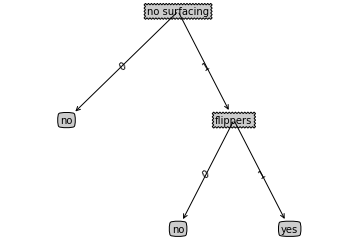

In [23]:
create_plot(retrieve_tree(0))

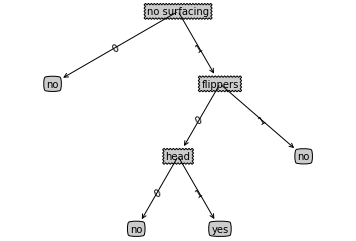

In [24]:
create_plot(retrieve_tree(1))

## 3. Testing and storing the classifier
### 3.1 Test: using the tree for classification

In [25]:
# 在执行数据分类时，程序比较测试数据与决策树上的数值
# Do this recursively until it hits a leaf node.
# Then, it will stop because it has arrived at a conclusion.

def classify(input_tree, feature_labels, test_vec):
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feature_index = feature_labels.index(first_str)
    key = test_vec[feature_index]
    feature_value = second_dict[key]
    if isinstance(feature_value, dict): 
        class_label = classify(feature_value, feature_labels, test_vec)
    else: 
        class_label = feature_value
    return class_label


In [26]:
# test simple example

my_data, labels = create_dataset()

print(classify(retrieve_tree(0), labels, [0,1]))
print(classify(retrieve_tree(0), labels, [1,1]))

print(classify(retrieve_tree(1), labels, [0,1]))
print(classify(retrieve_tree(1), labels, [1,1]))

no
yes
no
no


### 3.2 Use: persisting the decision tree

In [27]:
def store_tree(input_tree, filename):
    import pickle
    fw = open(filename, 'w')
    for key, value in input_tree.items():
        fw.write('%s:%s' % (key, value))
    fw.close()
    
    
def grab_tree(filename):
    fr = open(filename)
    data = dict()
    for item in fr:
        if ':' in item:
            key, value = item.split(':', 1)
            data[key]=value
            return data
        else:
            pass    # deal with bad lines of text here


In [28]:
store_tree(my_tree,'/Users/elinabian 1/Desktop/CU-life/summerlearning/mlinaction/dataset/classifierStorage.txt')
grab_tree('/Users/elinabian 1/Desktop/CU-life/summerlearning/mlinaction/dataset/classifierStorage.txt')

{'no surfacing': "{0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}"}

## 4. Example: using decision trees to predict contact lens type (预测隐形眼镜类型)

In [29]:
fr = open('/Users/elinabian 1/Desktop/CU-life/summerlearning/mlinaction/dataset/lenses.txt')
lenses=[inst.strip().split('\t') for inst in fr.readlines()]
lenses_labels=['age', 'prescript', 'astigmatic', 'tearRate']
lenses_tree = create_tree(lenses, lenses_labels)
lenses_tree

{'tearRate': {'reduced': 'no lenses',
  'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'young': 'soft',
      'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}}},
    'yes': {'prescript': {'myope': 'hard',
      'hyper': {'age': {'pre': 'no lenses',
        'young': 'hard',
        'presbyopic': 'no lenses'}}}}}}}}

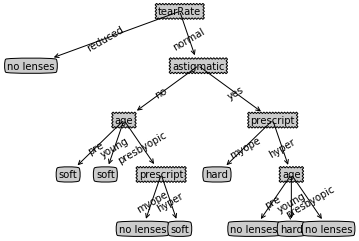

In [30]:
create_plot(lenses_tree)

<font size = 3.5>This decision tree probably matches our data too well, which is known as **overfitting**. In order to reduce the problem, we can prune the tree, that is to go through and remove some leaves. If a leaf node adds only a little information, it will be cut off and merged with another leaf.
<br>
<br>
The algorithm we used in this chapter, ID3, is good but not the best. ID3 can’t handle **numeric values**. We could use continuous values by quantizing them into discrete bins, but ID3 suffers from other problems if we have too many splits.</font>